<a href="https://colab.research.google.com/github/ccyyyYyzz/GI_GAN/blob/main/GI_GAN_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All the results of the GAN training models here are saved as graphs and not directly displayed

/usr/local/lib/python3.11/dist-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


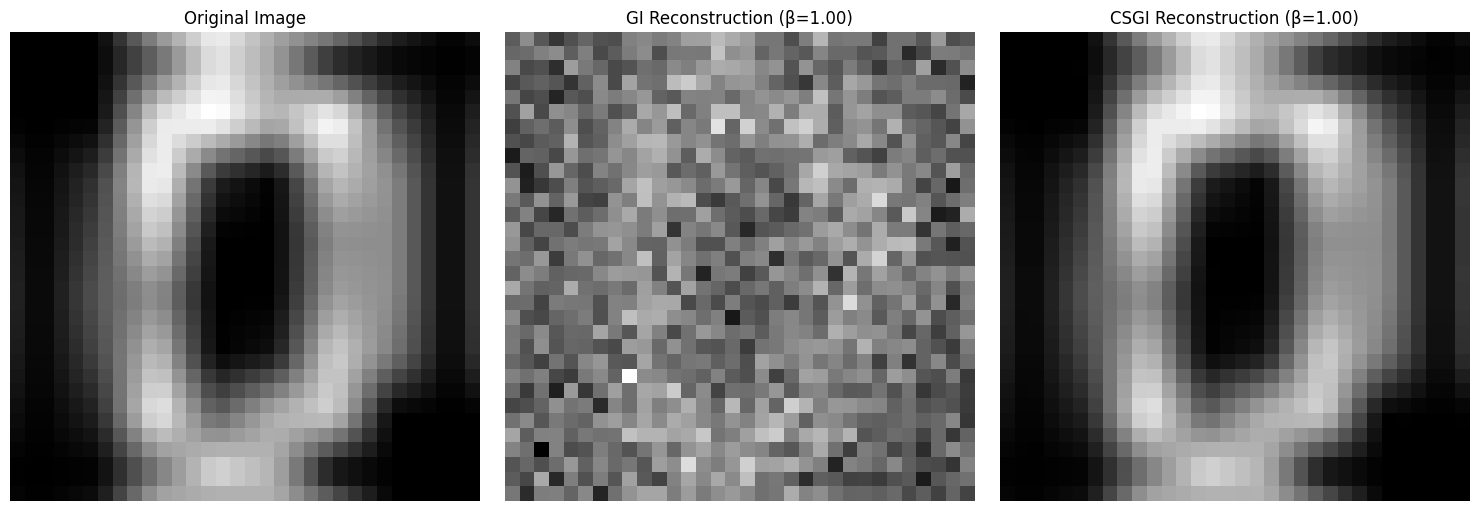

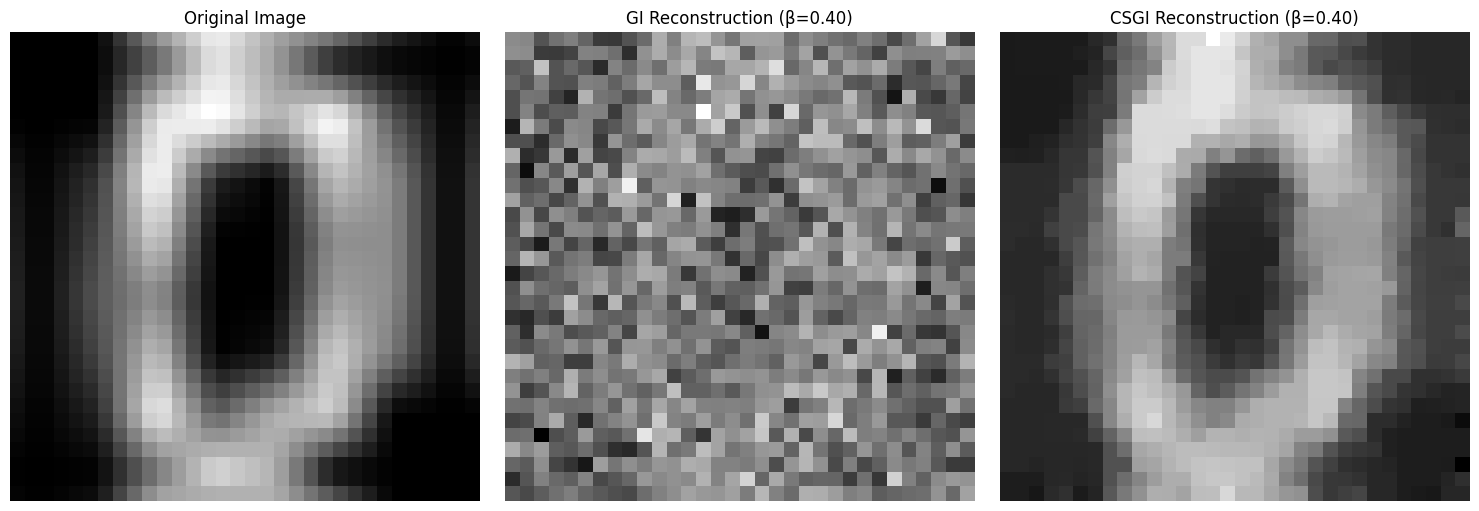

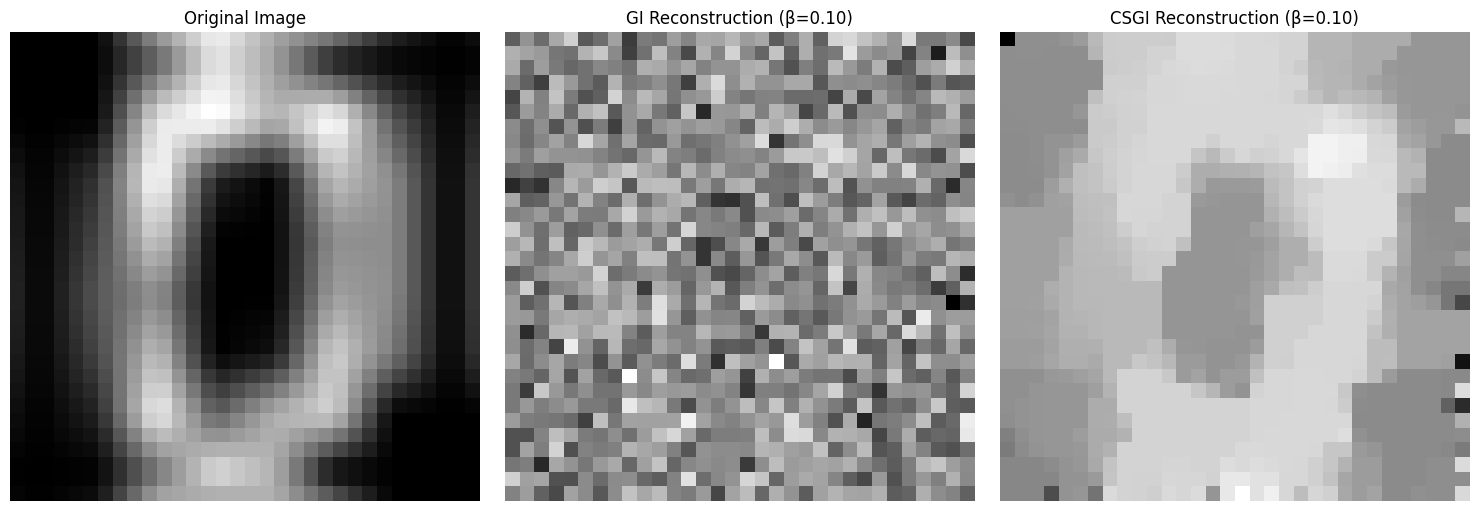

In [1]:
#original figure, GI, CSGI (different beta)
# # 预处理第一版
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import cvxpy as cp
from skimage.restoration import denoise_tv_chambolle

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install cvxpy scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 数据准备

def prepare_data(image_size=32):
    # 加载MNIST数据集
    digits = load_digits()

    # 选择一个数字图像并调整大小
    image = digits.images[0]
    image = resize(image, (image_size, image_size), anti_aliasing=True)

    return image

# 生成随机speckle模式
def generate_speckle_patterns(num_patterns, image_size):
    return np.random.rand(num_patterns, image_size, image_size)

# 计算bucket信号
def calculate_bucket_signal(image, speckle_patterns):
    return np.sum(image * speckle_patterns, axis=(1, 2))

# 传统鬼影成像重构
def gi_reconstruction(bucket_signal, speckle_patterns):
    mean_bucket = np.mean(bucket_signal)
    mean_speckle = np.mean(speckle_patterns, axis=0)

    delta_bucket = bucket_signal - mean_bucket
    delta_speckle = speckle_patterns - mean_speckle

    reconstruction = np.mean(delta_bucket[:, np.newaxis, np.newaxis] * delta_speckle, axis=0)
    return reconstruction

# 压缩感知鬼影成像重构
def csgi_reconstruction(bucket_signal, speckle_patterns, lambda_tv):
    image_size = speckle_patterns.shape[1]
    num_patterns = speckle_patterns.shape[0]

    # 将speckle模式展平为矩阵A
    A = speckle_patterns.reshape(num_patterns, -1)

    # 定义优化问题
    x = cp.Variable(image_size * image_size)
    objective = cp.Minimize(cp.sum_squares(A @ x - bucket_signal) + lambda_tv * cp.tv(cp.reshape(x, (image_size, image_size))))
    prob = cp.Problem(objective)

    # 求解优化问题
    prob.solve()

    # 重塑结果为图像
    reconstruction = x.value.reshape(image_size, image_size)
    return reconstruction

# 可视化结果
def visualize_results(original, gi_recon, csgi_recon, sampling_rate):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(gi_recon, cmap='gray')
    axes[1].set_title(f'GI Reconstruction (β={sampling_rate:.2f})')
    axes[2].imshow(csgi_recon, cmap='gray')
    axes[2].set_title(f'CSGI Reconstruction (β={sampling_rate:.2f})')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 主函数
def main():
    image_size = 32
    original_image = prepare_data(image_size)

    sampling_rates = [1.0, 0.4, 0.1]

    for beta in sampling_rates:
        num_patterns = int(beta * image_size * image_size)
        speckle_patterns = generate_speckle_patterns(num_patterns, image_size)

        # 计算bucket信号
        bucket_signal = calculate_bucket_signal(original_image, speckle_patterns)

        # 传统GI重构
        gi_recon = gi_reconstruction(bucket_signal, speckle_patterns)

        # CSGI重构
        lambda_tv = 0.1  # 可以调整这个参数以获得更好的结果
        csgi_recon = csgi_reconstruction(bucket_signal, speckle_patterns, lambda_tv)

        # 可视化结果
        visualize_results(original_image, gi_recon, csgi_recon, beta)

if __name__ == "__main__":
    main()


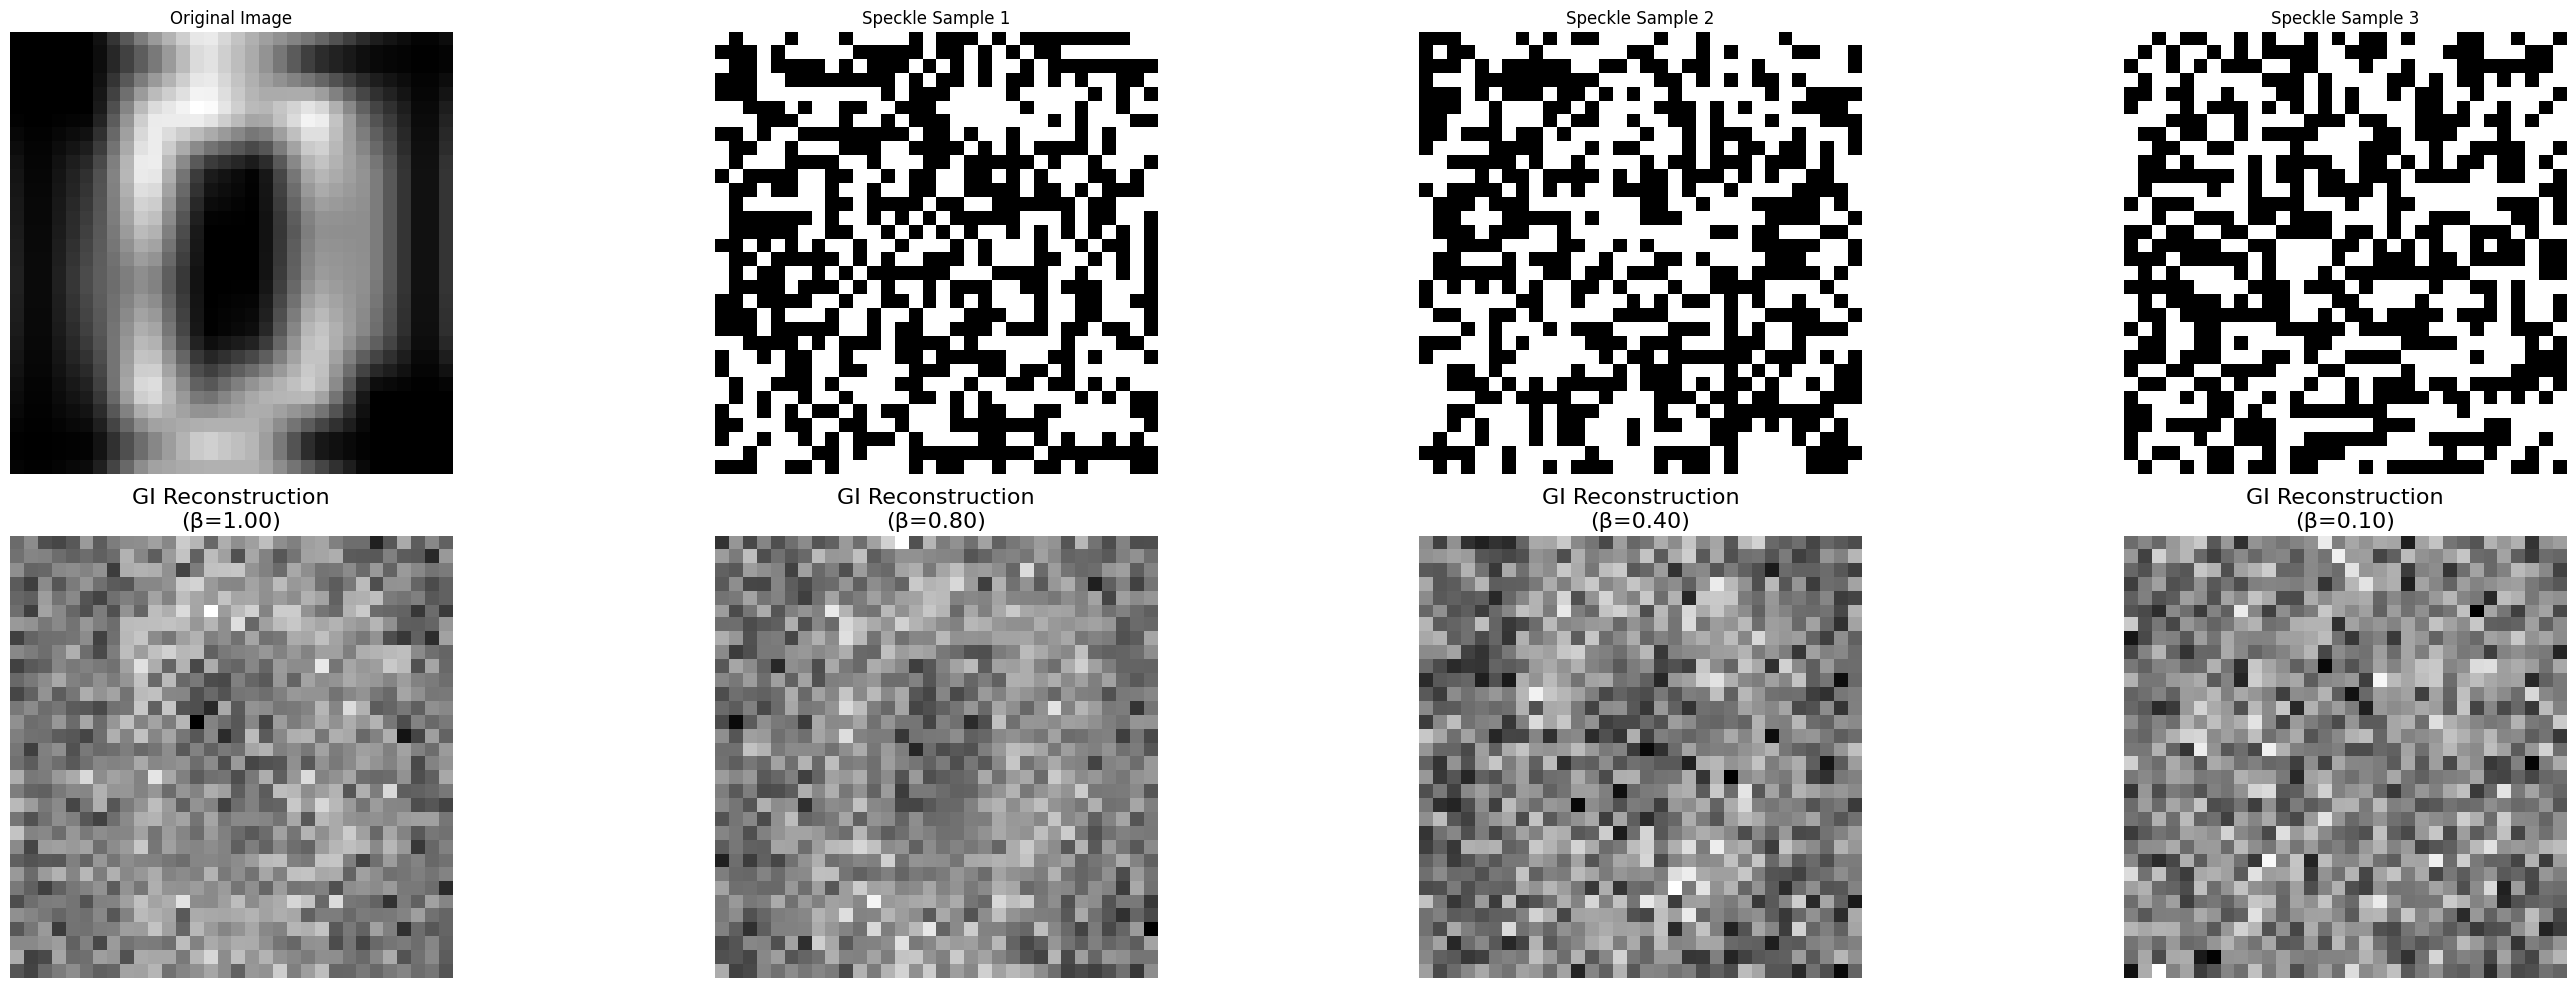

In [16]:
# 预处理第二版
# 这个和第一个mmodule差不多，但改了一下，可视化了一下散斑
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 数据准备
def prepare_data(image_size=32):
    """
    从MNIST数据集加载并预处理手写数字图像
    """
    # 加载MNIST数据集
    digits = load_digits()
    # 选择一个数字图像并调整大小
    image = digits.images[0]
    image = resize(image, (image_size, image_size), anti_aliasing=True)
    # 归一化图像到0-1范围
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

# 生成随机speckle模式
def generate_speckle_patterns(num_patterns, image_size):
    """
    生成随机的二值speckle光斑模式
    """
    return np.random.randint(0, 2, (num_patterns, image_size, image_size))

# 计算bucket信号
def calculate_bucket_signal(image, speckle_patterns):
    """
    计算每个speckle模式对目标图像的积分
    """
    return np.sum(image * speckle_patterns, axis=(1, 2))

# 传统鬼影成像重构
def gi_reconstruction(bucket_signal, speckle_patterns):
    """
    使用传统GI方法重构图像
    """
    mean_bucket = np.mean(bucket_signal)
    mean_speckle = np.mean(speckle_patterns, axis=0)
    delta_bucket = bucket_signal - mean_bucket
    delta_speckle = speckle_patterns - mean_speckle
    reconstruction = np.mean(delta_bucket[:, np.newaxis, np.newaxis] * delta_speckle, axis=0)
    return reconstruction

# 可视化结果
def visualize_results(original, speckle_samples, reconstructions, sampling_rates):
    """
    可视化原始图像、speckle样本和重构结果
    """
    num_rates = len(sampling_rates)
    fig, axes = plt.subplots(2, num_rates, figsize=(5 * (num_rates + 2), 10))

    # 显示原始图像
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # 显示speckle样本
    for i in range(3):
        axes[0, i+1].imshow(speckle_samples[i], cmap='binary')
        axes[0, i+1].set_title(f'Speckle Sample {i+1}')
        axes[0, i+1].axis('off')

    for i, (beta, recon) in enumerate(zip(sampling_rates, reconstructions)):
        # 归一化重构结果到0-1范围
        recon_norm = (recon - np.min(recon)) / (np.max(recon) - np.min(recon))
        axes[1, i].imshow(recon_norm, cmap='gray')
        axes[1, i].set_title(f'GI Reconstruction\n(β={beta:.2f})', fontsize=16)
        axes[1, i].axis('off')

    plt.tight_layout(pad=1.0)  # 增加子图之间的间距
    plt.show()

# 主函数
def main():
    image_size = 32
    original_image = prepare_data(image_size)
    sampling_rates = [1.0, 0.8, 0.4, 0.1]
    reconstructions = []

    # 生成一些speckle样本用于可视化
    speckle_samples = generate_speckle_patterns(3, image_size)

    for beta in sampling_rates:
        num_patterns = int(beta * image_size * image_size)
        speckle_patterns = generate_speckle_patterns(num_patterns, image_size)

        # 计算bucket信号
        bucket_signal = calculate_bucket_signal(original_image, speckle_patterns)

        # 传统GI重构
        gi_recon = gi_reconstruction(bucket_signal, speckle_patterns)
        reconstructions.append(gi_recon)

    # 可视化结果
    visualize_results(original_image, speckle_samples, reconstructions, sampling_rates)

if __name__ == "__main__":
    main()


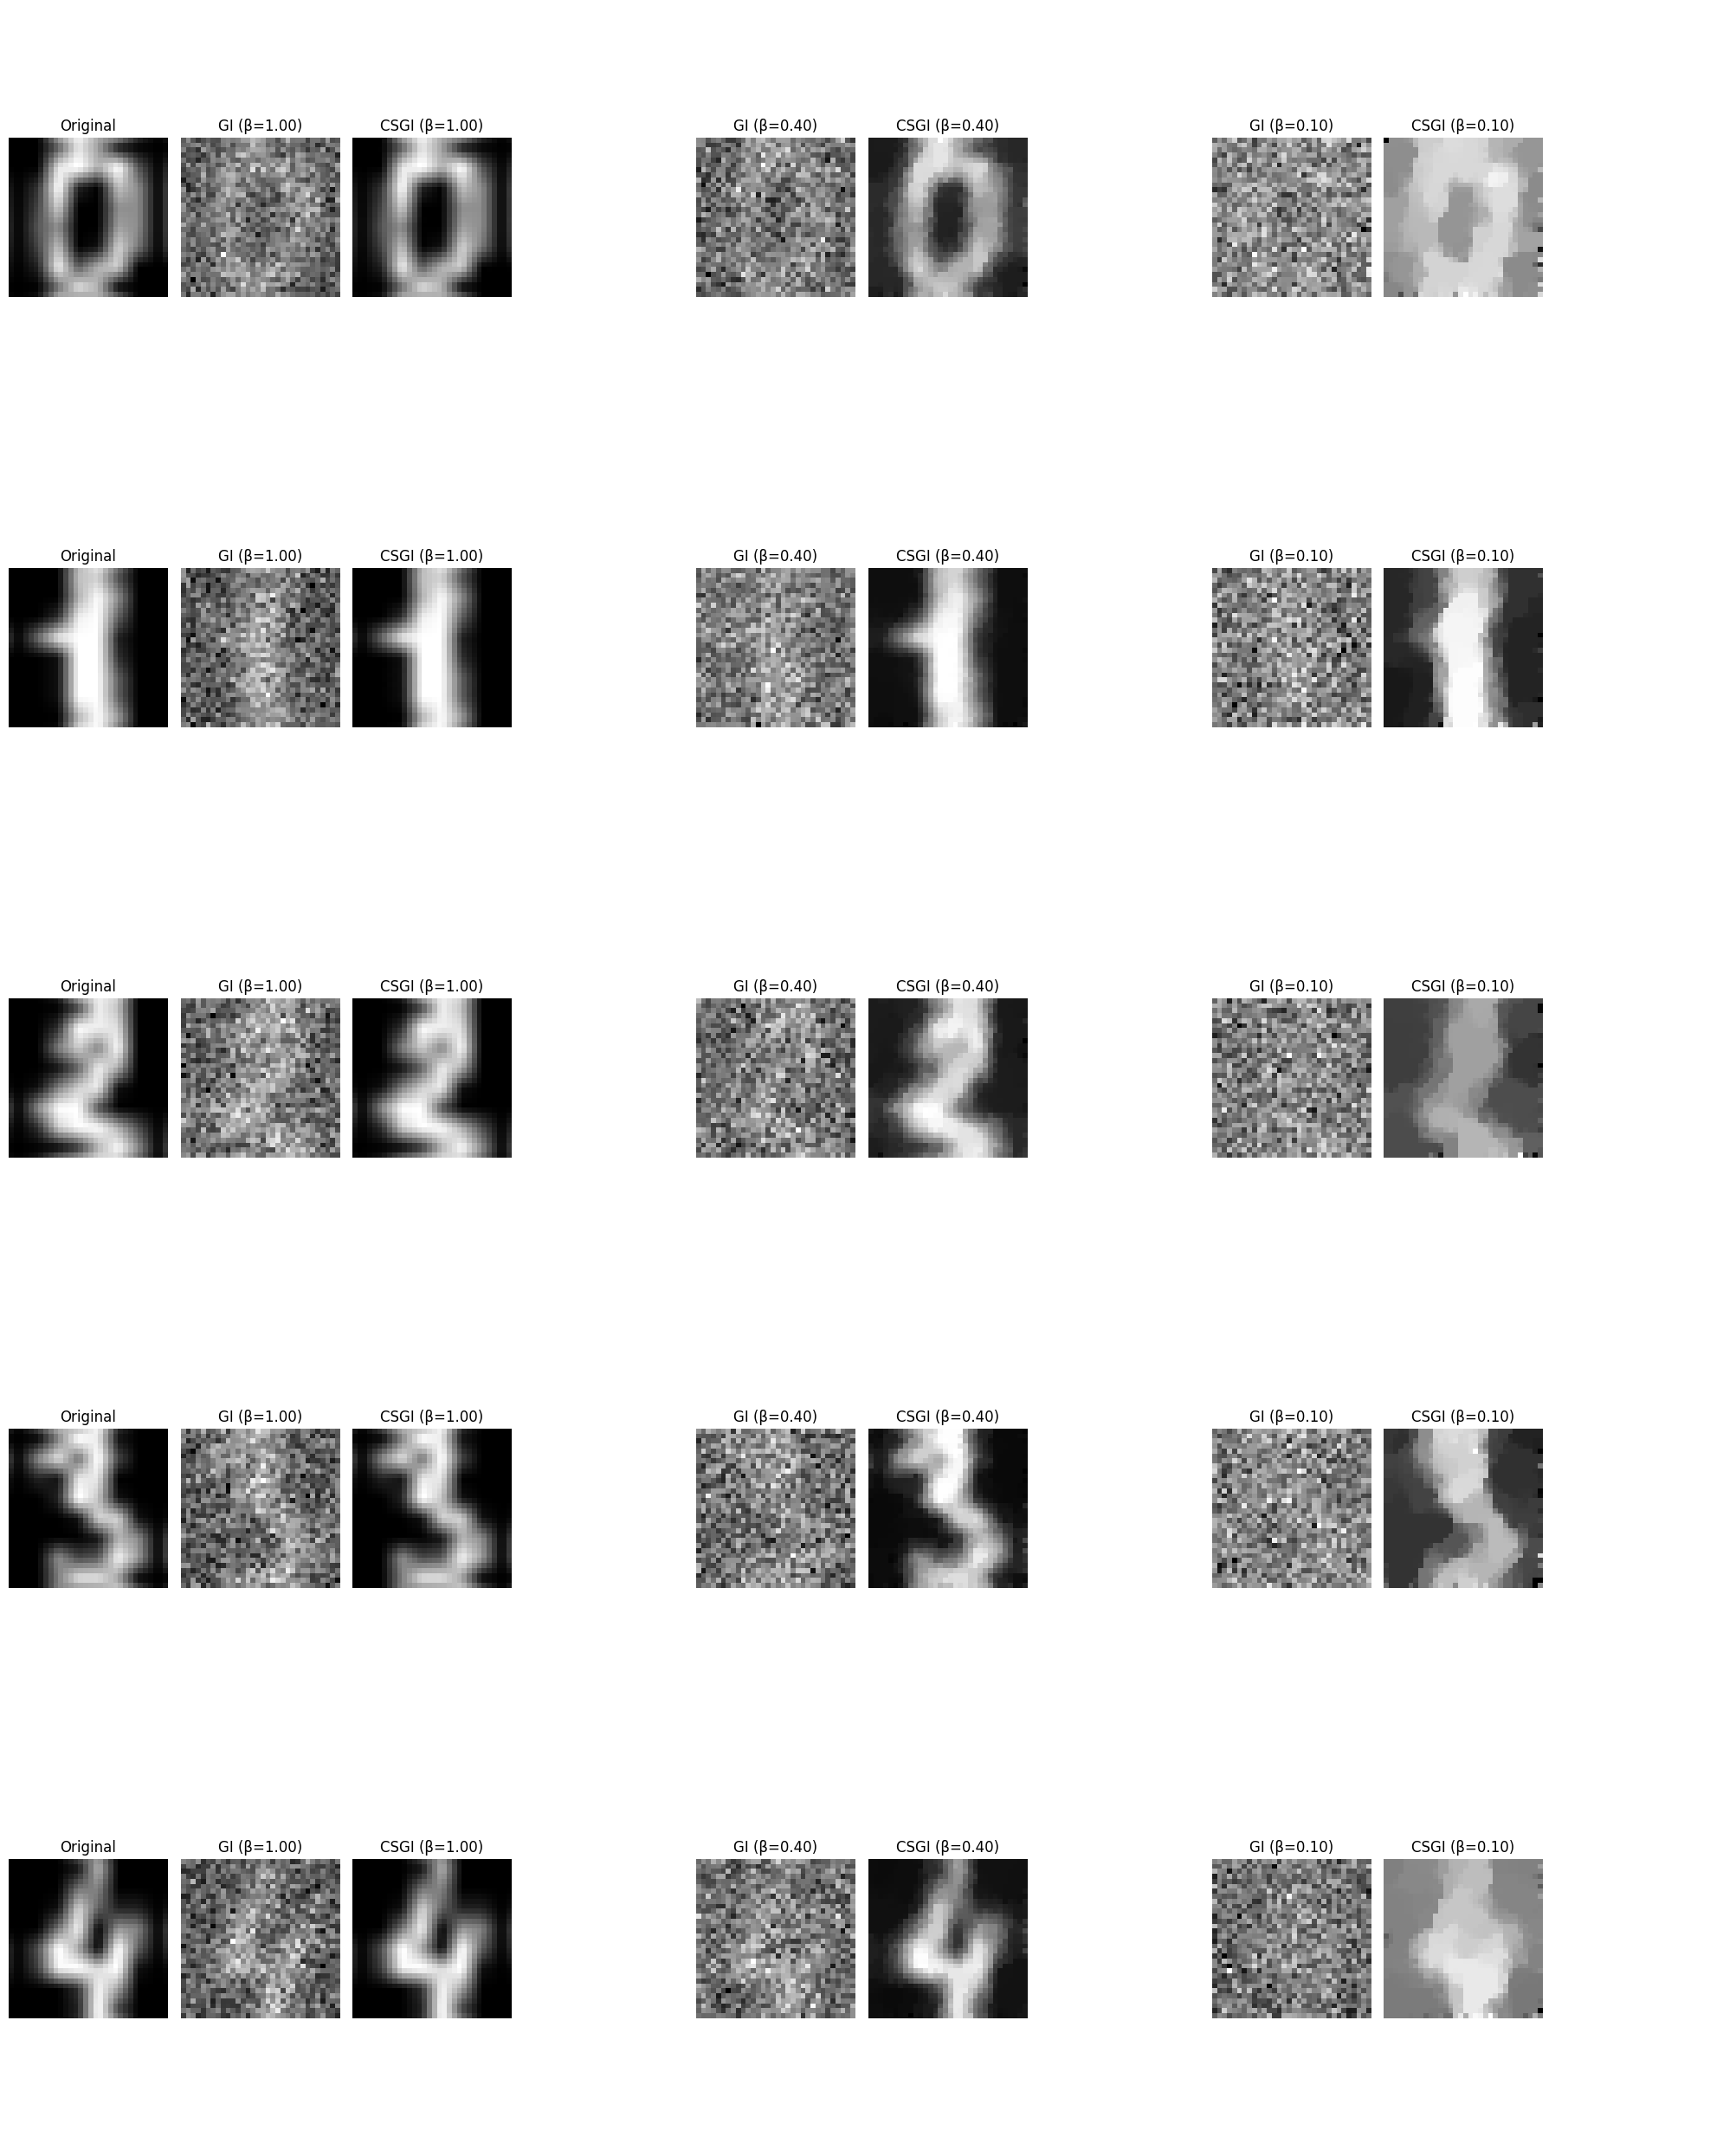

In [2]:
# 预处理第三版
# 增多了几个样本，可视化好一点
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import cvxpy as cp
from skimage.restoration import denoise_tv_chambolle

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install cvxpy scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 数据准备
def prepare_data(num_images=5, image_size=32):
    # 加载MNIST数据集
    digits = load_digits()

    # 选择多个数字图像并调整大小
    images = []
    for i in range(num_images):
        image = digits.images[i]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)

    return images

# 生成随机speckle模式
def generate_speckle_patterns(num_patterns, image_size):
    return np.random.rand(num_patterns, image_size, image_size)

# 计算bucket信号
def calculate_bucket_signal(image, speckle_patterns):
    return np.sum(image * speckle_patterns, axis=(1, 2))

# 传统鬼影成像重构
def gi_reconstruction(bucket_signal, speckle_patterns):
    mean_bucket = np.mean(bucket_signal)
    mean_speckle = np.mean(speckle_patterns, axis=0)

    delta_bucket = bucket_signal - mean_bucket
    delta_speckle = speckle_patterns - mean_speckle

    reconstruction = np.mean(delta_bucket[:, np.newaxis, np.newaxis] * delta_speckle, axis=0)
    return reconstruction

# 压缩感知鬼影成像重构
def csgi_reconstruction(bucket_signal, speckle_patterns, lambda_tv):
    image_size = speckle_patterns.shape[1]
    num_patterns = speckle_patterns.shape[0]

    # 将speckle模式展平为矩阵A
    A = speckle_patterns.reshape(num_patterns, -1)

    # 定义优化问题
    x = cp.Variable(image_size * image_size)
    objective = cp.Minimize(cp.sum_squares(A @ x - bucket_signal) + lambda_tv * cp.tv(cp.reshape(x, (image_size, image_size))))
    prob = cp.Problem(objective)

    # 求解优化问题
    prob.solve()

    # 重塑结果为图像
    reconstruction = x.value.reshape(image_size, image_size)
    return reconstruction

# 可视化结果
def visualize_results(originals, gi_recons, csgi_recons, sampling_rates):
    num_images = len(originals)
    num_rates = len(sampling_rates)

    fig, axes = plt.subplots(num_images, 3 * num_rates + 1, figsize=(5 * num_rates + 5, 5 * num_images))

    for i, original in enumerate(originals):
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        for j, beta in enumerate(sampling_rates):
            axes[i, 3*j + 1].imshow(gi_recons[i][j], cmap='gray')
            axes[i, 3*j + 1].set_title(f'GI (β={beta:.2f})')
            axes[i, 3*j + 1].axis('off')

            axes[i, 3*j + 2].imshow(csgi_recons[i][j], cmap='gray')
            axes[i, 3*j + 2].set_title(f'CSGI (β={beta:.2f})')
            axes[i, 3*j + 2].axis('off')

            axes[i, 3*j + 3].axis('off')  # 空白列，用于分隔不同采样率的结果

    plt.tight_layout()
    plt.show()

# 主函数
def main():
    image_size = 32
    num_images = 5
    original_images = prepare_data(num_images, image_size)

    sampling_rates = [1.0, 0.4, 0.1]

    all_gi_recons = []
    all_csgi_recons = []

    for original_image in original_images:
        gi_recons = []
        csgi_recons = []

        for beta in sampling_rates:
            num_patterns = int(beta * image_size * image_size)
            speckle_patterns = generate_speckle_patterns(num_patterns, image_size)

            # 计算bucket信号
            bucket_signal = calculate_bucket_signal(original_image, speckle_patterns)

            # 传统GI重构
            gi_recon = gi_reconstruction(bucket_signal, speckle_patterns)
            gi_recons.append(gi_recon)

            # CSGI重构
            lambda_tv = 0.1  # 可以调整这个参数以获得更好的结果
            csgi_recon = csgi_reconstruction(bucket_signal, speckle_patterns, lambda_tv)
            csgi_recons.append(csgi_recon)

        all_gi_recons.append(gi_recons)
        all_csgi_recons.append(csgi_recons)

    # 可视化结果
    visualize_results(original_images, all_gi_recons, all_csgi_recons, sampling_rates)

if __name__ == "__main__":
    main()


In [18]:
# 第一次GAN尝试，（CNN的尝试在其他地方）
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 数据准备
def prepare_data(num_images=1000, image_size=32):
    """
    从MNIST数据集加载并预处理手写数字图像
    """
    # 加载MNIST数据集
    digits = load_digits()

    # 选择多个数字图像并调整大小
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)

    # 归一化图像
    images = np.array(images)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))

    return images

# 生成初步重构图像（模拟传统GI结果）
def generate_initial_reconstructions(images, noise_level=0.3):
    """
    生成带有噪声的初步重构图像，模拟传统GI结果
    """
    noise = np.random.normal(0, noise_level, images.shape)
    initial_reconstructions = np.clip(images + noise, 0, 1)
    return initial_reconstructions

# 定义生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),

        # 编码器部分
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),

        # 解码器部分
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid')
    ])
    return model

# 定义判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# 定义GAN模型
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, initial_reconstructions = data

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            d_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                     self.loss_fn(tf.zeros_like(fake_output), fake_output)

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 训练GAN
def train_gan(gan, dataset, epochs=100, batch_size=32):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch in dataset.batch(batch_size):
            gan.train_step(batch)

        # 每10个epoch显示一次生成结果
        if (epoch + 1) % 10 == 0:
            display_results(gan, dataset, epoch + 1)

# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    initial_reconstructions = next(iter(dataset.batch(n)))[1]
    generated_images = gan.generator(initial_reconstructions, training=False)

    fig, axes = plt.subplots(3, n, figsize=(15, 9))
    for i in range(n):
        axes[0, i].imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Initial')

        axes[1, i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Generated')

        axes[2, i].imshow(next(iter(dataset.batch(n)))[0][i, :, :, 0], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('Original')

    plt.tight_layout()
    plt.savefig(f'gan_results_epoch_{epoch}.png')
    plt.close()

# 主函数
def main():
    # 准备数据
    images = prepare_data(num_images=1000)
    initial_reconstructions = generate_initial_reconstructions(images)

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((images[..., np.newaxis], initial_reconstructions[..., np.newaxis]))
    dataset = dataset.shuffle(buffer_size=1000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()
    gan = GAN(generator, discriminator)

    # 编译GAN模型
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy()
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=100, batch_size=32)

    # 显示最终结果
    display_results(gan, dataset, epoch=100)

if __name__ == "__main__":
    main()
#这个主要是发现问题（1）可视化处original图片对不上  （2）Epoch比较大的时候，图片质量好像下降了，过拟合

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

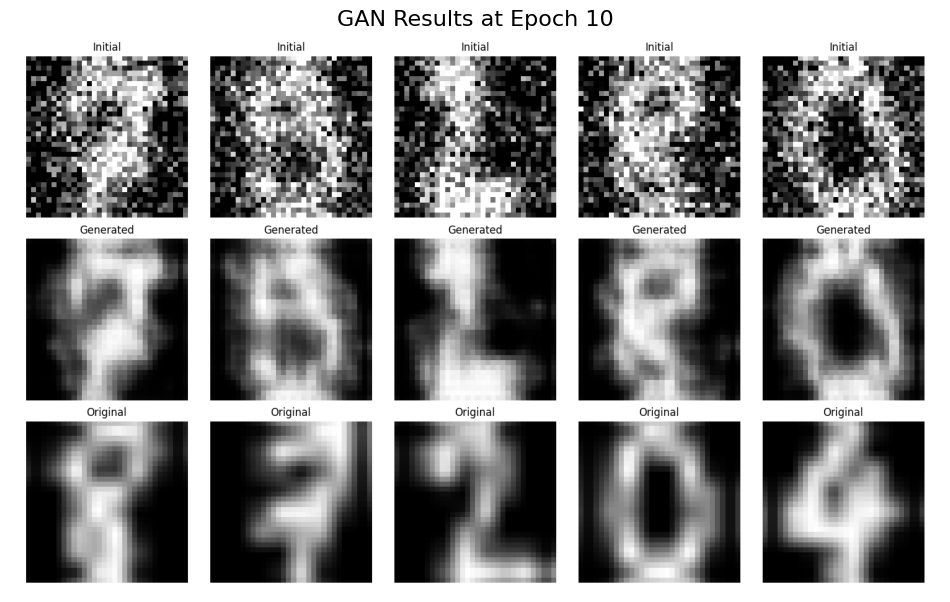

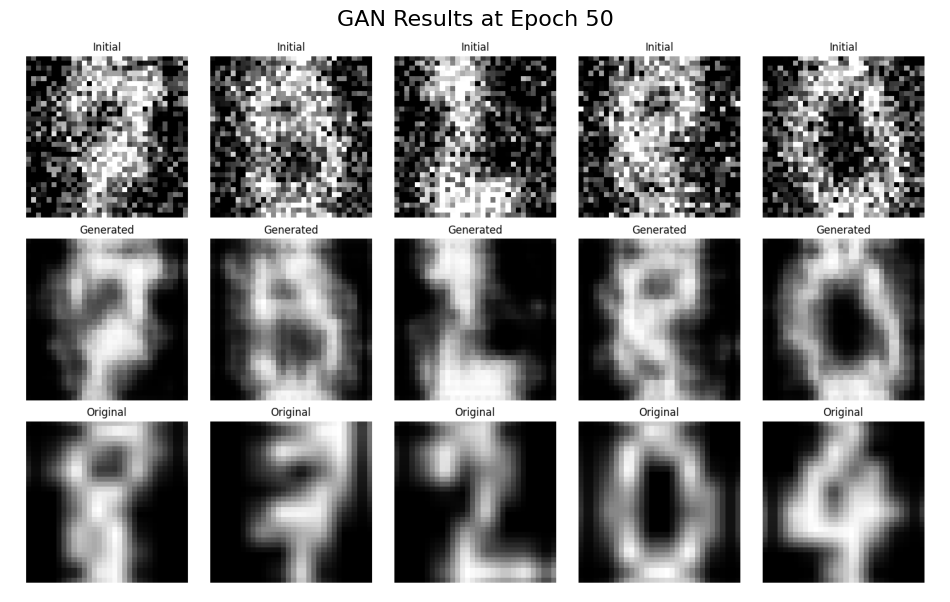

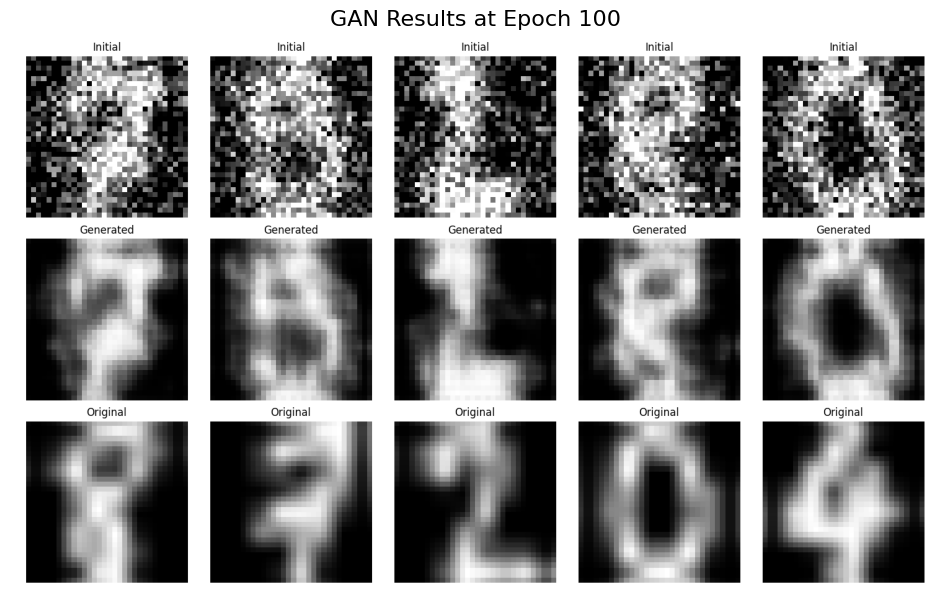

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 读取图像
image_path1 = '/content/gan_results_epoch_10.png'
image_path2 = '/content/gan_results_epoch_50.png'
image_path3 = '/content/gan_results_epoch_100.png'
img = Image.open(image_path1)

# 将图像转换为numpy数组
img_array = np.array(img)
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()
img = Image.open(image_path2)
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()
img = Image.open(image_path3)
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 100', fontsize=16)
plt.show()

In [4]:
# 第二版，解决了original图对不上的问题，并改了参数epoch减少，数据集增大
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 数据准备
def prepare_data(num_images=5000, image_size=32):
    """
    从MNIST数据集加载并预处理手写数字图像
    """
    # 加载MNIST数据集
    digits = load_digits()

    # 选择多个数字图像并调整大小
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)

    # 归一化图像
    images = np.array(images)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))

    return images

# 生成初步重构图像（模拟传统GI结果）
def generate_initial_reconstructions(images, noise_level=0.3):
    """
    生成带有噪声的初步重构图像，模拟传统GI结果
    """
    noise = np.random.normal(0, noise_level, images.shape)
    initial_reconstructions = np.clip(images + noise, 0, 1)
    return initial_reconstructions

# 定义生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),

        # 编码器部分
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),

        # 解码器部分
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid')
    ])
    return model

# 定义判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# 定义GAN模型
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, initial_reconstructions = data

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            d_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                     self.loss_fn(tf.zeros_like(fake_output), fake_output)

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 训练GAN
def train_gan(gan, dataset, epochs=10, batch_size=32):
    g_losses = []
    d_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_g_losses = []
        epoch_d_losses = []
        for batch in dataset.batch(batch_size):
            losses = gan.train_step(batch)
            epoch_g_losses.append(losses['g_loss'].numpy())
            epoch_d_losses.append(losses['d_loss'].numpy())

        g_losses.append(np.mean(epoch_g_losses))
        d_losses.append(np.mean(epoch_d_losses))

        # 每10个epoch显示一次生成结果
        if (epoch + 1) % 1 == 0:
            display_results(gan, dataset, epoch + 1)

    # 绘制损失函数变化图
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Losses')
    plt.savefig('gan_losses.png')
    plt.close()

# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    sample = next(iter(dataset.batch(n)))
    original_images, initial_reconstructions = sample
    generated_images = gan.generator(initial_reconstructions, training=False)

    fig, axes = plt.subplots(3, n, figsize=(15, 9))
    for i in range(n):
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('GI')

        axes[2, i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('GIDL')

    plt.tight_layout()
    plt.savefig(f'GAN_results_epoch_{epoch}.png')
    plt.close()

# 主函数
def main():
    # 准备数据
    images = prepare_data(num_images=5000)
    initial_reconstructions = generate_initial_reconstructions(images)

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((images[..., np.newaxis], initial_reconstructions[..., np.newaxis]))
    dataset = dataset.shuffle(buffer_size=5000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()
    gan = GAN(generator, discriminator)

    # 编译GAN模型
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy()
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=10, batch_size=32)

    # 显示最终结果
    display_results(gan, dataset, epoch=10)

if __name__ == "__main__":
    main()


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


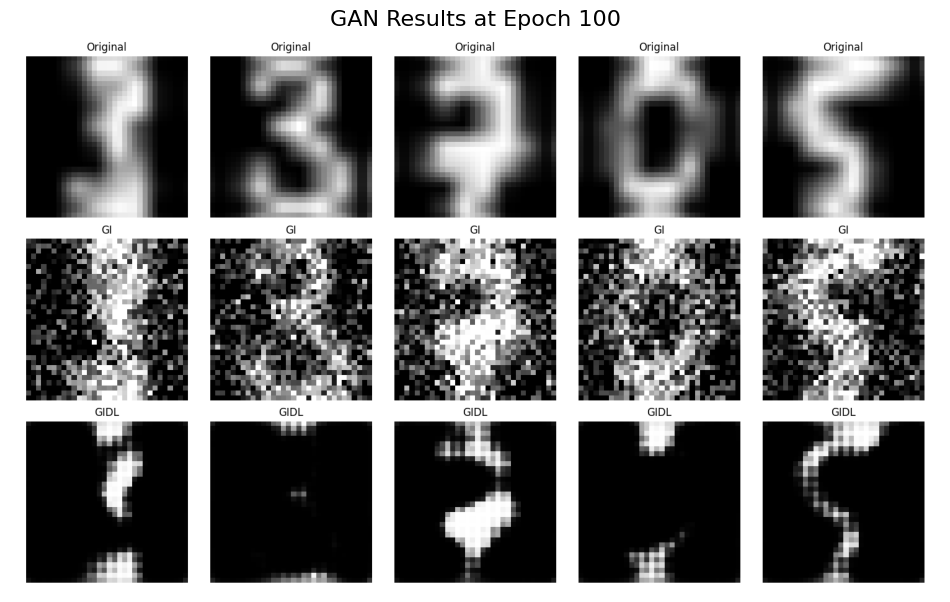

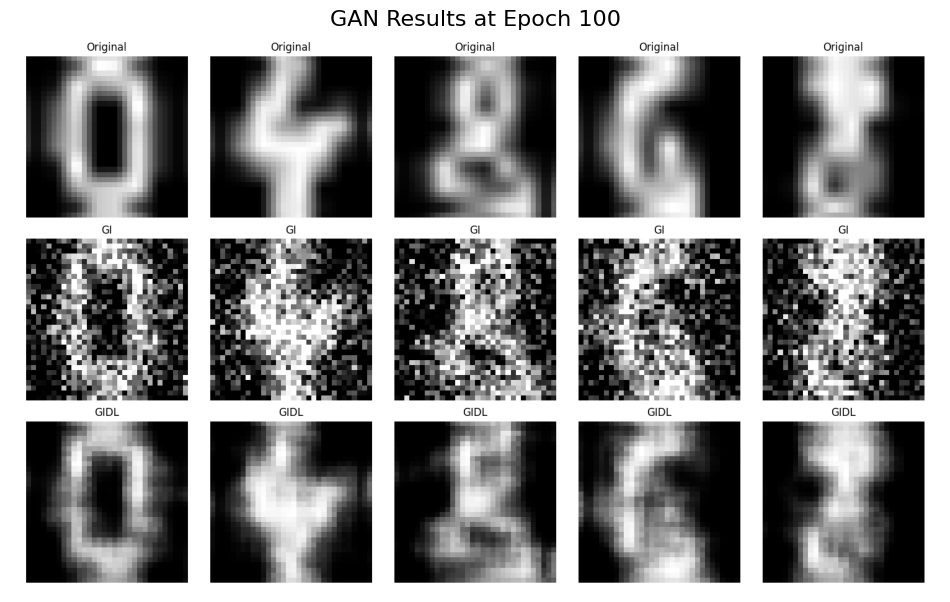

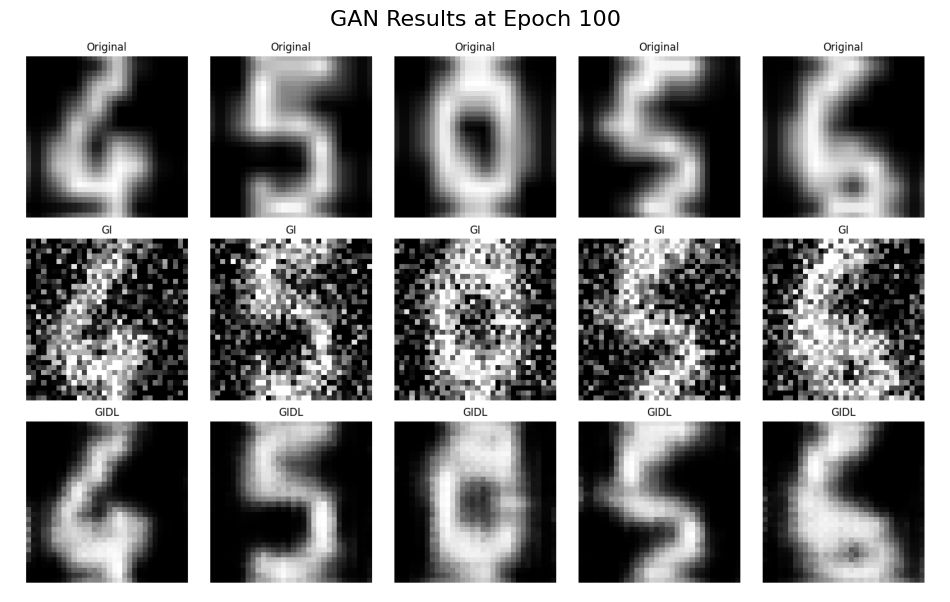

In [21]:
# 读取图像
image_path = '/content/GAN_results_epoch_1.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 100', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAN_results_epoch_5.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 100', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAN_results_epoch_10.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 100', fontsize=16)
plt.show()

In [5]:
#在生成器中添加了BatchNormalization层

#在判别器中使用了Dropout层来防止过拟合，并移除了最后的sigmoid激活函数。

#将生成器的最后一层激活函数改为tanh

#在GAN的compile方法中，使用了BinaryCrossentropy(from_logits=True)作为损失函数

#在训练循环中，我们现在打印每个epoch的损失值，以便更好地监控训练过程。

# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 数据准备
def prepare_data(num_images=5000, image_size=32):
    """
    从MNIST数据集加载并预处理手写数字图像
    """
    # 加载MNIST数据集
    digits = load_digits()

    # 选择多个数字图像并调整大小
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)

    # 归一化图像
    images = np.array(images)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))

    return images

# 生成初步重构图像（模拟传统GI结果）
def generate_initial_reconstructions(images, noise_level=0.3):
    """
    生成带有噪声的初步重构图像，模拟传统GI结果
    """
    noise = np.random.normal(0, noise_level, images.shape)
    initial_reconstructions = np.clip(images + noise, 0, 1)
    return initial_reconstructions

# 修改生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),

        # 编码器部分
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # 解码器部分
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='tanh')
    ])
    return model

# 修改判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# 定义GAN模型
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, initial_reconstructions = data
        batch_size = tf.shape(real_images)[0]

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = real_loss + fake_loss

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 训练GAN
def train_gan(gan, dataset, epochs=100, batch_size=32):
    g_losses = []
    d_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_g_losses = []
        epoch_d_losses = []
        for batch in dataset.batch(batch_size):
            losses = gan.train_step(batch)
            epoch_g_losses.append(losses['g_loss'].numpy())
            epoch_d_losses.append(losses['d_loss'].numpy())

        g_losses.append(np.mean(epoch_g_losses))
        d_losses.append(np.mean(epoch_d_losses))

        print(f"G Loss: {g_losses[-1]:.4f}, D Loss: {d_losses[-1]:.4f}")

        # 每10个epoch显示一次生成结果
        if (epoch + 1) % 10 == 0:
            display_results(gan, dataset, epoch + 1)

    # 绘制损失函数变化图
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Losses')
    plt.savefig('gan_losses.png')
    plt.close()

# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    sample = next(iter(dataset.batch(n)))
    original_images, initial_reconstructions = sample
    generated_images = gan.generator(initial_reconstructions, training=False)

    fig, axes = plt.subplots(3, n, figsize=(15, 9))
    for i in range(n):
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('GI')

        axes[2, i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('GIDL')

    plt.tight_layout()
    plt.savefig(f'GAN2_results_epoch_{epoch}.png')
    plt.close()


# 主函数
def main():
    # 准备数据
    images = prepare_data(num_images=5000)
    initial_reconstructions = generate_initial_reconstructions(images)

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((images[..., np.newaxis], initial_reconstructions[..., np.newaxis]))
    dataset = dataset.shuffle(buffer_size=5000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()
    gan = GAN(generator, discriminator)

    # 编译GAN模型
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=10, batch_size=32)

    # 显示最终结果
    display_results(gan, dataset, epoch=10)

if __name__ == "__main__":
    main()


Epoch 1/10
G Loss: 1.2035, D Loss: 0.8596
Epoch 2/10
G Loss: 1.2286, D Loss: 0.8785
Epoch 3/10
G Loss: 1.4245, D Loss: 0.7923
Epoch 4/10
G Loss: 1.5559, D Loss: 0.7552
Epoch 5/10
G Loss: 1.8010, D Loss: 0.6524
Epoch 6/10
G Loss: 1.8267, D Loss: 0.6389
Epoch 7/10
G Loss: 2.0981, D Loss: 0.5711
Epoch 8/10
G Loss: 2.2327, D Loss: 0.5198
Epoch 9/10
G Loss: 2.4668, D Loss: 0.4358
Epoch 10/10
G Loss: 2.6543, D Loss: 0.3818


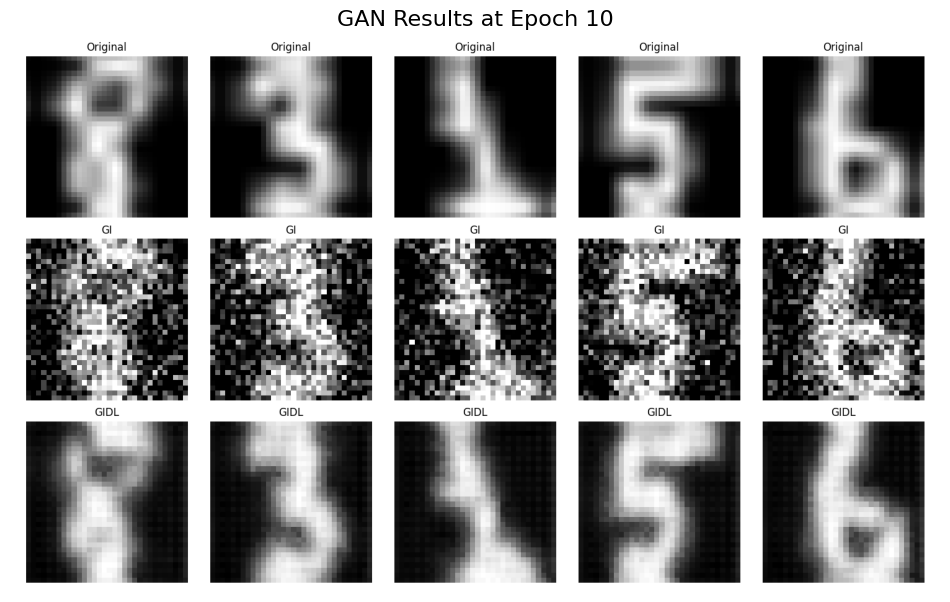

In [22]:
# 读取图像
image_path = '/content/GAN2_results_epoch_10.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()



In [7]:
# 改用gpu,这里使用A100,是用claude改的代码
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 检查是否有可用的GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# 如果有GPU，设置内存增长
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 数据准备函数
def prepare_data(num_images=5000, image_size=32):
    digits = load_digits()
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)
    images = np.array(images)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    return images

# 生成初步重构图像函数
def generate_initial_reconstructions(images, noise_level=0.3):
    noise = np.random.normal(0, noise_level, images.shape)
    initial_reconstructions = np.clip(images + noise, 0, 1)
    return initial_reconstructions

# 生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='tanh')
    ])
    return model

# 判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# GAN模型
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, initial_reconstructions = data
        batch_size = tf.shape(real_images)[0]

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = real_loss + fake_loss

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 训练GAN
def train_gan(gan, dataset, epochs=10, batch_size=32):
    g_losses = []
    d_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_g_losses = []
        epoch_d_losses = []
        for batch in dataset.batch(batch_size):
            losses = gan.train_step(batch)
            epoch_g_losses.append(losses['g_loss'].numpy())
            epoch_d_losses.append(losses['d_loss'].numpy())

        g_losses.append(np.mean(epoch_g_losses))
        d_losses.append(np.mean(epoch_d_losses))

        print(f"G Loss: {g_losses[-1]:.4f}, D Loss: {d_losses[-1]:.4f}")

        # 每个epoch显示一次生成结果
        display_results(gan, dataset, epoch + 1)

    # 绘制损失函数变化图
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Losses')
    plt.savefig('gan_losses.png')
    plt.close()

# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    sample = next(iter(dataset.batch(n)))
    original_images, initial_reconstructions = sample
    generated_images = gan.generator(initial_reconstructions, training=False)

    fig, axes = plt.subplots(3, n, figsize=(15, 9))
    for i in range(n):
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('GI')

        axes[2, i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('GIDL')

    plt.tight_layout()
    plt.savefig(f'gan3_results_epoch_{epoch}.png')
    plt.close()

# 主函数
def main():
    # 准备数据
    images = prepare_data(num_images=5000)
    initial_reconstructions = generate_initial_reconstructions(images)

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((images[..., np.newaxis], initial_reconstructions[..., np.newaxis]))
    dataset = dataset.shuffle(buffer_size=5000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()
    gan = GAN(generator, discriminator)

    # 编译GAN模型
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=10, batch_size=32)

    # 显示最终结果
    display_results(gan, dataset, epoch=10)

if __name__ == "__main__":
    main()


Num GPUs Available:  1
Physical devices cannot be modified after being initialized
Epoch 1/10
G Loss: 1.0713, D Loss: 0.9488
Epoch 2/10
G Loss: 1.0458, D Loss: 1.0526
Epoch 3/10
G Loss: 1.0939, D Loss: 1.0049
Epoch 4/10
G Loss: 1.1696, D Loss: 0.9246
Epoch 5/10
G Loss: 1.2135, D Loss: 0.8852
Epoch 6/10
G Loss: 1.2860, D Loss: 0.8226
Epoch 7/10
G Loss: 1.4011, D Loss: 0.7539
Epoch 8/10
G Loss: 1.4910, D Loss: 0.6905
Epoch 9/10
G Loss: 1.6087, D Loss: 0.6246
Epoch 10/10
G Loss: 1.7417, D Loss: 0.5631


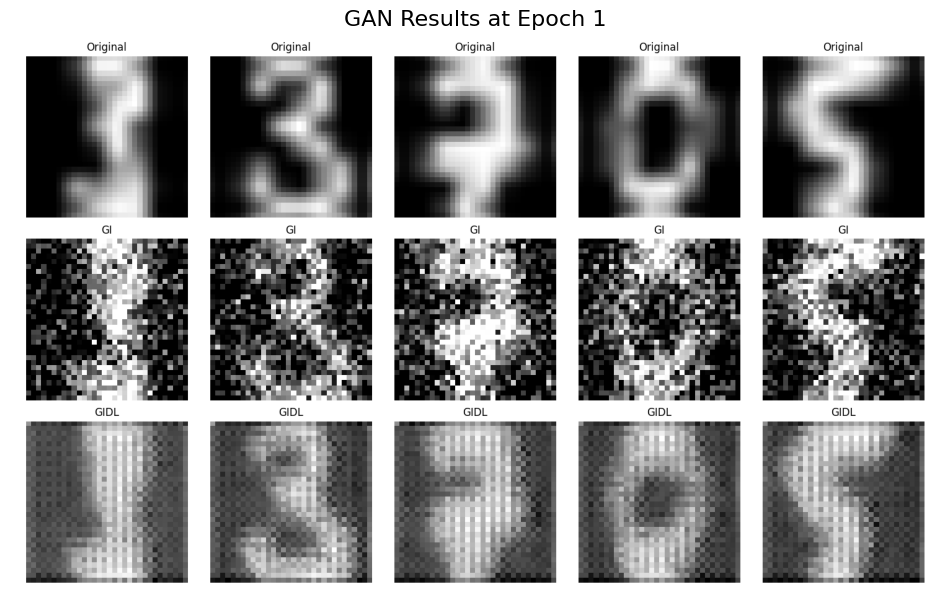

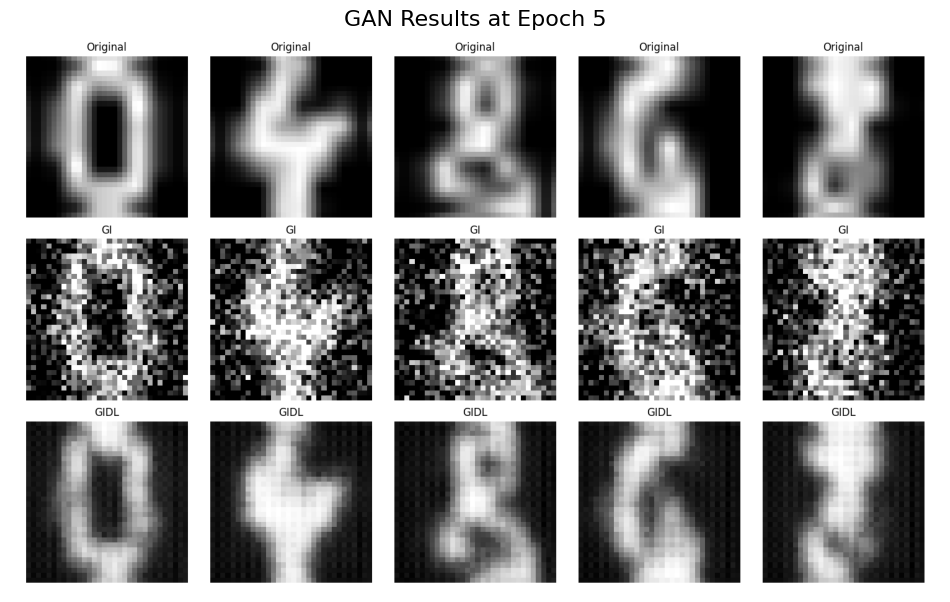

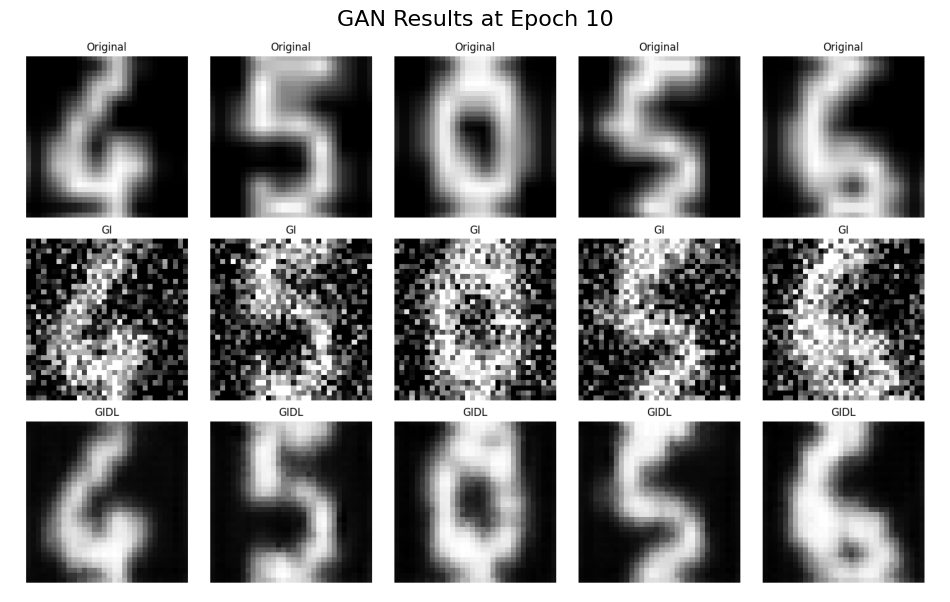

In [24]:
# 读取图像
image_path = '/content/gan3_results_epoch_1.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 1', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/gan3_results_epoch_5.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 5', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/gan3_results_epoch_10.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()